# 🧠 Data Exploration - Robot Navigation Training Data

**Goals:**
1. Generate training data with enhanced features (5×5 perception + 12 action history = 37 features)
2. Load and inspect dataset
3. View sample data examples  
4. Analyze key matrix properties
5. Examine data distribution

**Note:** This notebook supports both 3×3 (21 features) and 5×5 (37 features) perception modes.

In [9]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

from core.data_generation import load_training_data

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Configuration Options

**Unified Configuration System:**

| Mode | Perception | Features | Config File | Description |
|------|------------|----------|-------------|-------------|
| **Enhanced 3×3** | 3×3 + history | 21 | `nn_config.yaml` | Standard navigation (76.7%) |
| **Enhanced 5×5** | 5×5 + history | 37 | `nn_config.yaml` | Advanced navigation (79.1%) |

**Usage with Unified Config:**
```bash
# Generate datasets
python scripts/generate_data.py large                    # 3×3 enhanced (21 features)
python scripts/generate_data.py large --perception 5x5   # 5×5 enhanced (37 features)

# Train models (auto-configures based on perception mode)
python scripts/train_nn.py --perception 3x3              # Uses 3×3 config
python scripts/train_nn.py --perception 5x5              # Uses 5×5 config
```

**Benefits:**
- ✅ Single config file for both modes
- ✅ Automatic input_size calculation
- ✅ No duplicate configuration files
- ✅ Easy switching between perception modes


---
## 1. Generate Training Data

**Skip this section if data already exists in `data/raw/`**

In [9]:
# Generate large dataset with 5×5 perception (37 features)
# Uncomment to run:

"""
result = subprocess.run(
    [sys.executable, "scripts/generate_data.py", "large", "--perception", "5x5"],
    cwd=project_root,
    capture_output=True,
    text=True,
    check=True
)
print(result.stdout)
"""

'\nresult = subprocess.run(\n    [sys.executable, "scripts/generate_data.py", "large", "--perception", "5x5"],\n    cwd=project_root,\n    capture_output=True,\n    text=True,\n    check=True\n)\nprint(result.stdout)\n'

---
## 2. Load Dataset

In [10]:
# Load the training dataset
X_train, y_train, metadata = load_training_data("../data/raw/distance_5x5_large.npz")

# Detect perception type (binary vs distance-based)
sample_perception = X_train[0][:25] if X_train.shape[1] >= 25 else X_train[0][:9]
unique_vals = np.unique(sample_perception)
is_distance_based = len(unique_vals) > 2 or (len(unique_vals) == 2 and not (0.0 in unique_vals and 1.0 in unique_vals))

perception_type = "Distance-based 🎯" if is_distance_based else "Binary"

print("✅ Dataset loaded successfully!")
print(f"   Training examples: {len(X_train)}")
print(f"   Environments: {len(metadata)}")
print(f"   Perception type: {perception_type}")

📂 Training data loaded from ../data/raw/distance_5x5_large.npz
✅ Dataset loaded successfully!
   Training examples: 8901
   Environments: 1000
   Perception type: Distance-based 🎯


---
## 3. Key Matrix Properties

In [11]:
# Display key properties
print("📊 DATASET PROPERTIES")
print("=" * 60)

# Shape and size
print(f"\n🔢 Shape & Size:")
print(f"   X_train shape: {X_train.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   Total samples: {len(X_train):,}")

# Data types
print(f"\n📝 Data Types:")
print(f"   X_train dtype: {X_train.dtype}")
print(f"   y_train dtype: {y_train.dtype}")

# Value ranges
print(f"\n📏 Value Ranges:")
print(f"   X_train: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"   y_train: [{y_train.min()}, {y_train.max()}]")

# Memory usage
x_memory_mb = X_train.nbytes / (1024 * 1024)
y_memory_mb = y_train.nbytes / (1024 * 1024)
total_memory_mb = x_memory_mb + y_memory_mb
print(f"\n💾 Memory Usage:")
print(f"   X_train: {x_memory_mb:.2f} MB")
print(f"   y_train: {y_memory_mb:.2f} MB")
print(f"   Total: {total_memory_mb:.2f} MB")

# Feature breakdown
feature_count = X_train.shape[1]
print(f"\n🧠 Feature Breakdown:")
if feature_count == 37:
    print(f"   ✅ Enhanced 5×5 Mode: {feature_count} features")
    print(f"      • Perception: 25 features (5×5 grid)")
    print(f"      • History: 12 features (3 actions × 4 one-hot)")
elif feature_count == 21:
    print(f"   ✅ Enhanced 3×3 Mode: {feature_count} features")
    print(f"      • Perception: 9 features (3×3 grid)")
    print(f"      • History: 12 features (3 actions × 4 one-hot)")
    print(f"   ✅ Enhanced Mode: {feature_count} features")
    print(f"      • Perception: 9 features (3×3 grid)")
    print(f"      • History: 12 features (3 actions × 4 one-hot)")
elif feature_count == 25:
    print(f"   ⚠️  Basic 5×5 Mode: {feature_count} features (perception only)")
elif feature_count == 9:
    print(f"   ⚠️  Basic 3×3 Mode: {feature_count} features (perception only)")
    print(f"   ⚠️  Basic Mode: {feature_count} features (perception only)")
else:
    print(f"   ❓ Unknown Mode: {feature_count} features")

# Action labels
print(f"\n🎯 Action Labels:")
action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
for i, name in enumerate(action_names):
    print(f"   {i}: {name}")

📊 DATASET PROPERTIES

🔢 Shape & Size:
   X_train shape: (8901, 37)
   y_train shape: (8901,)
   Total samples: 8,901

📝 Data Types:
   X_train dtype: float32
   y_train dtype: int8

📏 Value Ranges:
   X_train: [0.0, 1.0]
   y_train: [0, 3]

💾 Memory Usage:
   X_train: 1.26 MB
   y_train: 0.01 MB
   Total: 1.26 MB

🧠 Feature Breakdown:
   ✅ Enhanced 5×5 Mode: 37 features
      • Perception: 25 features (5×5 grid)
      • History: 12 features (3 actions × 4 one-hot)

🎯 Action Labels:
   0: UP
   1: DOWN
   2: LEFT
   3: RIGHT


---
## 4. Sample Data Examples

In [12]:
# Display sample training examples
print("👁️  SAMPLE TRAINING EXAMPLES")
print("=" * 60)

action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
num_samples = 5

for i in range(num_samples):
    sample_idx = np.random.randint(0, len(X_train))
    sample_x = X_train[sample_idx]
    sample_y = y_train[sample_idx]
    
    print(f"\nExample {i+1} (index {sample_idx}):")
    
    # Dynamic feature detection and display
    feature_count = X_train.shape[1]
    
    if feature_count == 37:
        # Enhanced 5×5 mode: 25 perception + 12 history
        perception = sample_x[:25].reshape(5, 5)
        history = sample_x[25:37].reshape(3, 4)
        
        print(f"  5×5 Perception {'(Distance)' if is_distance_based else '(Binary)'}:")
        for row in perception:
            if is_distance_based:
                # Show distance values
                print(f"    {' '.join([f'{x:.1f}' for x in row])}")
            else:
                # Show binary (X for obstacle, . for free)
                print(f"    {' '.join(['X' if x > 0 else '.' for x in row])}")
        
        print("  Action History (last 3 actions):")
        for j, action_vec in enumerate(history):
            action_idx = np.argmax(action_vec) if np.sum(action_vec) > 0 else -1
            if action_idx >= 0:
                print(f"    {j+1}. {action_names[action_idx]}")
            else:
                print(f"    {j+1}. (no action)")
                
    elif feature_count == 21:
        # Enhanced 3×3 mode: 9 perception + 12 history
        perception = sample_x[:9].reshape(3, 3)
        history = sample_x[9:21].reshape(3, 4)
        
        print(f"  3×3 Perception {'(Distance)' if is_distance_based else '(Binary)'}:")
        for row in perception:
            if is_distance_based:
                print(f"    {' '.join([f'{x:.1f}' for x in row])}")
            else:
                print(f"    {' '.join(['X' if x > 0 else '.' for x in row])}")
        
        print("  Action History (last 3 actions):")
        for j, action_vec in enumerate(history):
            action_idx = np.argmax(action_vec) if np.sum(action_vec) > 0 else -1
            if action_idx >= 0:
                print(f"    {j+1}. {action_names[action_idx]}")
            else:
                print(f"    {j+1}. (no action)")
                
    elif feature_count == 25:
        # Basic 5×5 mode: perception only
        perception = sample_x.reshape(5, 5)
        print(f"  5×5 Perception {'(Distance)' if is_distance_based else '(Binary)'}:")
        for row in perception:
            if is_distance_based:
                print(f"    {' '.join([f'{x:.1f}' for x in row])}")
            else:
                print(f"    {' '.join(['X' if x > 0 else '.' for x in row])}")
            
    elif feature_count == 9:
        # Basic 3×3 mode: perception only
        perception = sample_x.reshape(3, 3)
        print(f"  3×3 Perception {'(Distance)' if is_distance_based else '(Binary)'}:")
        for row in perception:
            if is_distance_based:
                print(f"    {' '.join([f'{x:.1f}' for x in row])}")
            else:
                print(f"    {' '.join(['X' if x > 0 else '.' for x in row])}")
            
    else:
        print(f"  Unknown feature format: {feature_count} features")
        print(f"  Raw features: {sample_x[:10]}...")  # Show first 10 features
    
    print(f"  → Action: {action_names[sample_y]}")

👁️  SAMPLE TRAINING EXAMPLES

Example 1 (index 4379):
  5×5 Perception (Distance):
    0.2 0.2 0.0 0.0 0.0
    0.0 0.2 0.0 0.0 0.0
    0.2 0.4 0.2 0.0 0.0
    0.2 0.2 0.0 0.0 0.0
    0.0 0.2 0.0 0.0 0.0
  Action History (last 3 actions):
    1. (no action)
    2. (no action)
    3. (no action)
  → Action: LEFT

Example 2 (index 8484):
  5×5 Perception (Distance):
    0.0 0.2 0.2 0.2 0.0
    0.0 0.2 0.2 0.0 0.2
    0.0 0.0 0.2 0.2 0.4
    0.0 0.2 0.2 0.4 0.6
    0.0 0.2 0.0 0.2 0.4
  Action History (last 3 actions):
    1. LEFT
    2. LEFT
    3. LEFT
  → Action: UP

Example 3 (index 3908):
  5×5 Perception (Distance):
    0.0 0.2 0.2 0.2 0.2
    0.0 0.2 0.0 0.0 0.0
    0.0 0.2 0.2 0.2 0.2
    0.0 0.0 0.2 0.0 0.2
    0.0 0.0 0.2 0.2 0.4
  Action History (last 3 actions):
    1. UP
    2. UP
    3. UP
  → Action: LEFT

Example 4 (index 7607):
  5×5 Perception (Distance):
    0.0 0.2 0.0 0.2 0.0
    0.2 0.0 0.0 0.2 0.2
    0.4 0.2 0.2 0.2 0.4
    0.2 0.0 0.2 0.0 0.2
    0.2 0.0 0.2 0.0 0.

---
## 5. Data Distribution Analysis

In [13]:
# Action distribution
print("📊 ACTION DISTRIBUTION")
print("=" * 60)

action_counts = np.bincount(y_train.astype(int))
action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']

print("\nAction Counts:")
for name, count in zip(action_names, action_counts):
    percentage = (count / len(y_train)) * 100
    bar = '█' * int(percentage / 2)
    print(f"  {name:>6}: {count:>5} ({percentage:>5.1f}%) {bar}")

# Class balance
max_count = np.max(action_counts)
min_count = np.min(action_counts)
imbalance_ratio = max_count / min_count
print(f"\nClass Balance:")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}")
print(f"  Status: {'✅ Balanced' if imbalance_ratio < 1.5 else '⚠️  Imbalanced'}")

📊 ACTION DISTRIBUTION

Action Counts:
      UP:  2189 ( 24.6%) ████████████
    DOWN:  2258 ( 25.4%) ████████████
    LEFT:  2273 ( 25.5%) ████████████
   RIGHT:  2181 ( 24.5%) ████████████

Class Balance:
  Imbalance ratio: 1.04
  Status: ✅ Balanced


In [14]:
# Perception statistics (dynamic based on feature count)
print("👁️  PERCEPTION STATISTICS")
print("=" * 60)

# Determine perception size dynamically
feature_count = X_train.shape[1]
if feature_count == 37:
    perception_size = 25  # 5×5
    perception_desc = "5×5"
elif feature_count == 21:
    perception_size = 9   # 3×3
    perception_desc = "3×3"
elif feature_count == 25:
    perception_size = 25  # 5×5 basic
    perception_desc = "5×5"
elif feature_count == 9:
    perception_size = 9   # 3×3 basic
    perception_desc = "3×3"
else:
    perception_size = min(feature_count, 25)  # Default to max possible
    perception_desc = f"{int(perception_size**0.5)}×{int(perception_size**0.5)}"

print(f"\nAnalyzing {perception_desc} perception ({perception_size} features):")

# Extract perception features
perception_features = X_train[:, :perception_size]
obstacles_per_view = np.sum(perception_features, axis=1)

print(f"\nObstacles per {perception_desc} view:")
print(f"  Mean: {np.mean(obstacles_per_view):.2f}")
print(f"  Std:  {np.std(obstacles_per_view):.2f}")
print(f"  Min:  {np.min(obstacles_per_view):.0f}")
print(f"  Max:  {np.max(obstacles_per_view):.0f}")

print(f"\nObstacle count distribution:")
obstacle_counts = np.bincount(obstacles_per_view.astype(int))
for i, count in enumerate(obstacle_counts):
    if count > 0:
        percentage = (count / len(X_train)) * 100
        bar = '█' * int(percentage / 2)
        print(f"  {i} obstacles: {count:>5} ({percentage:>5.1f}%) {bar}")


👁️  PERCEPTION STATISTICS

Analyzing 5×5 perception (25 features):

Obstacles per 5×5 view:
  Mean: 4.55
  Std:  1.74
  Min:  1
  Max:  13

Obstacle count distribution:
  1 obstacles:   201 (  2.3%) █
  2 obstacles:  1243 ( 14.0%) ██████
  3 obstacles:  2134 ( 24.0%) ███████████
  4 obstacles:  2106 ( 23.7%) ███████████
  5 obstacles:  1423 ( 16.0%) ███████
  6 obstacles:   920 ( 10.3%) █████
  7 obstacles:   483 (  5.4%) ██
  8 obstacles:   215 (  2.4%) █
  9 obstacles:    95 (  1.1%) 
  10 obstacles:    41 (  0.5%) 
  11 obstacles:    28 (  0.3%) 
  12 obstacles:    11 (  0.1%) 
  13 obstacles:     1 (  0.0%) 


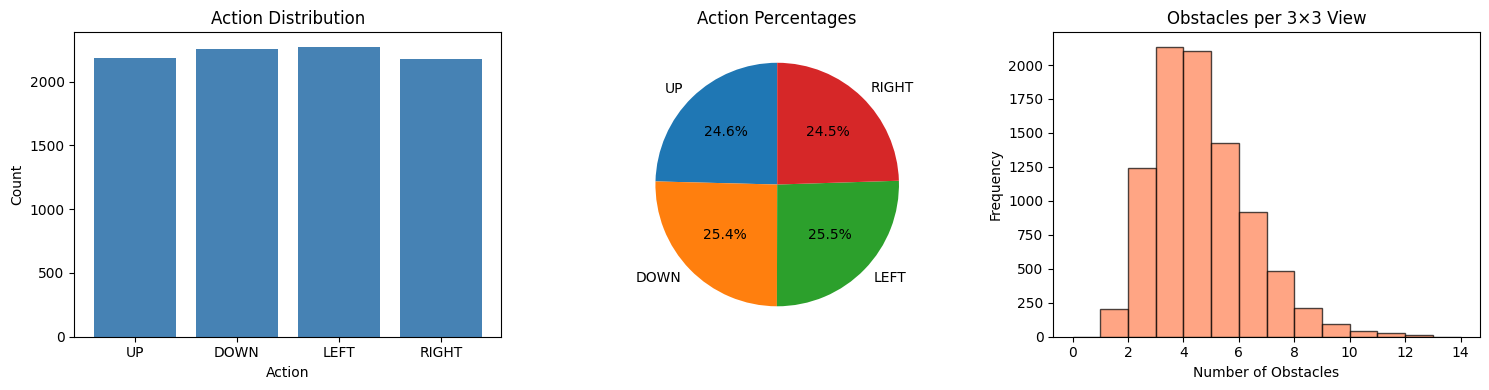


✅ Data exploration complete!


In [15]:
# Visualization: Action and Perception Distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Action distribution
axes[0].bar(action_names, action_counts, color='steelblue')
axes[0].set_title('Action Distribution')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Action')

# Action percentages
axes[1].pie(action_counts, labels=action_names, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Action Percentages')

# Obstacles per view histogram
axes[2].hist(obstacles_per_view, bins=range(int(np.max(obstacles_per_view))+2), 
             alpha=0.7, color='coral', edgecolor='black')
axes[2].set_title('Obstacles per 3×3 View')
axes[2].set_xlabel('Number of Obstacles')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n✅ Data exploration complete!")

---
## Summary

**Dataset Ready for Training:**
- ✅ Enhanced features (21: perception + history)
- ✅ Balanced action distribution
- ✅ Diverse obstacle patterns
- ✅ High-quality training examples

**Next Step:** Train neural network with this enhanced dataset